In [41]:
import os
import re
import pickle
import string
import unicodedata
from rouge import Rouge
from random import randint

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from wordcloud import STOPWORDS, WordCloud

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding, TimeDistributed

In [2]:
try:
  import keras.backend as K
  if len(K.tensorflow_backend._get_available_gpus()) > 0:
    from keras.layers import CuDNNLSTM as LSTM
    from keras.layers import CuDNNGRU as GRU
except:
  pass

In [3]:
from pre_func import *

In [4]:
filename = 'cleaned_data.csv'
df = pd.read_csv(filename, encoding='iso-8859-1').reset_index(drop=True)
df.headlines = df.headlines.apply(lambda x: f'_START_ {x} _END_')
start_token = 'sostok'
end_token = 'eostok'
df.headlines = df.headlines.apply(lambda x: f'{start_token} {x} {end_token}')
df.sample(5)

,Unnamed: 0,headlines,text
996,996,sostok _START_ mayweather posts picture millio...,following tweets claimed floyd mayweather run ...
30367,30367,sostok _START_ man screams death coming times ...,unidentified migrant deported uk italy reporte...
25851,25851,sostok _START_ sharman joshi star another erot...,bollywood actor sharman joshi news recently er...
31365,31365,sostok _START_ grew holes shoes jennifer lopez...,singer jennifer lopez speaking childhood days ...
32779,32779,sostok _START_ killed suicide attack northwest...,least eight people killed others injured suici...


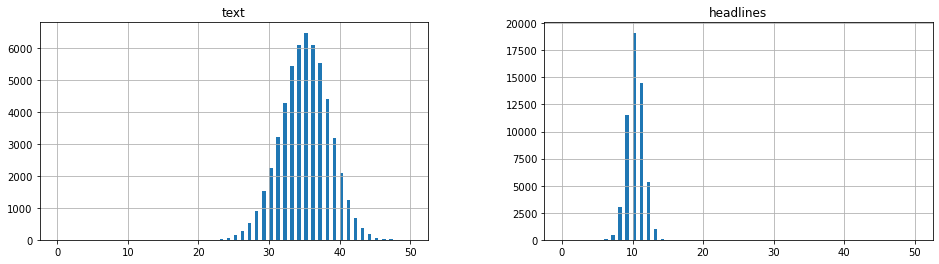

In [5]:
text_count = [len(sentence.split()) for sentence in df.text]
headlines_count = [len(sentence.split()) for sentence in df.headlines]
pd.DataFrame({'text': text_count, 'headlines': headlines_count}).hist(bins=100, figsize=(16, 4), range=[0, 50])
plt.show()

In [6]:
# Check how many % of headlines have 0-13 words
print(get_word_percent(df.headlines, 13))

# Check how many % of summary have 0-42 words
print(get_word_percent(df.text, 42))

1.0
0.99


In [7]:
max_text_len = 42
max_summary_len = 13

In [8]:
df = trim_text_and_summary(df, max_text_len, max_summary_len)
print(f'Dataset size: {len(df)}')
df.sample(5)

Dataset size: 54309


,text,summary
31459,samajwadi party suprthemo mulayam singh yadav ...,sostok _START_ dispute samajwadi party mulayam...
48905,us republican presidential nominee donald trum...,sostok _START_ donald trump secures early lead...
17193,new research revealed annual carbon themission...,sostok _START_ carbon themissions fell last de...
21155,indias womens football team defeated banglades...,sostok _START_ india win record th straight sa...
20923,maharashtra government set plant two crore sap...,sostok _START_ maharashtra govt plant crore sa...


In [9]:
# Splitting the training and validation sets
x_train, x_val, y_train, y_val = train_test_split(
    np.array(df['text']),
    np.array(df['summary']),
    test_size=0.1,
    random_state=1,
    shuffle=True
)

In [10]:
# rare word analysis
def get_rare_word_percent(tokenizer, threshold):
    # threshold: if the word's occurrence is less than this then it's rare word

    count = 0
    total_count = 0
    frequency = 0
    total_frequency = 0

    for key, value in tokenizer.word_counts.items():
        total_count += 1
        total_frequency += value
        if value < threshold:
            count += 1
            frequency += value

    return {
        'percent': round((count / total_count) * 100, 2),
        'total_coverage': round(frequency / total_frequency * 100, 2),
        'count': count,
        'total_count': total_count
    }

In [11]:
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))

x_tokens_data = get_rare_word_percent(x_tokenizer, 4)
print(x_tokens_data)

{'percent': 65.13, 'total_coverage': 4.18, 'count': 49630, 'total_count': 76207}


In [12]:
# save tokenizer
with open('x_tokenizer', 'wb') as f:
    pickle.dump(x_tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
# one-hot-encoding
x_train_sequence = x_tokenizer.texts_to_sequences(x_train)
x_val_sequence = x_tokenizer.texts_to_sequences(x_val)

# padding upto max_text_len
x_train_padded = pad_sequences(x_train_sequence, maxlen=max_text_len, padding='post')
x_val_padded = pad_sequences(x_val_sequence, maxlen=max_text_len, padding='post')

# if you're not using num_words parameter in Tokenizer then use this
x_vocab_size = len(x_tokenizer.word_index) + 1

# else use this
# x_vocab_size = x_tokenizer.num_words + 1

print(x_vocab_size)

76208


In [14]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

y_tokens_data = get_rare_word_percent(y_tokenizer, 6)
print(y_tokens_data)

{'percent': 73.82, 'total_coverage': 7.74, 'count': 21504, 'total_count': 29132}


In [15]:
# save tokenizer
with open('y_tokenizer', 'wb') as f:
    pickle.dump(y_tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

In [16]:
# one-hot-encoding
y_train_sequence = y_tokenizer.texts_to_sequences(y_train)
y_val_sequence = y_tokenizer.texts_to_sequences(y_val)

# padding upto max_summary_len
y_train_padded = pad_sequences(y_train_sequence, maxlen=max_summary_len, padding='post')
y_val_padded = pad_sequences(y_val_sequence, maxlen=max_summary_len, padding='post')

# if you're not using num_words parameter in Tokenizer then use this
y_vocab_size = len(y_tokenizer.word_index) + 1

# else use this
# y_vocab_size = y_tokenizer.num_words + 1

print(y_vocab_size)

29133


In [17]:
# removing summary which only has sostok & eostok
def remove_indexes(summary_array):
    remove_indexes = []
    for i in range(len(summary_array)):
        count = 0
        for j in summary_array[i]:
            if j != 0:
                count += 1
        if count == 2:
            remove_indexes.append(i)
    return remove_indexes


remove_train_indexes = remove_indexes(y_train_padded)
remove_val_indexes = remove_indexes(y_val_padded)

y_train_padded = np.delete(y_train_padded, remove_train_indexes, axis=0)
x_train_padded = np.delete(x_train_padded, remove_train_indexes, axis=0)

y_val_padded = np.delete(y_val_padded, remove_val_indexes, axis=0)
x_val_padded = np.delete(x_val_padded, remove_val_indexes, axis=0)

## Model

In [18]:
from model_func import *

In [19]:
latent_dim = 400
embedding_dim = 300
num_epochs = 30

In [20]:
x_embedding_matrix = get_embedding_matrix(x_tokenizer, embedding_dim, x_vocab_size)
y_embedding_matrix = get_embedding_matrix(y_tokenizer, embedding_dim, y_vocab_size)

Found 400000 word vectors.
Converted 49136 words (27071 misses)
Found 400000 word vectors.
Converted 22620 words (6512 misses)


In [21]:
print(x_embedding_matrix.shape)
print(y_embedding_matrix.shape)

(76208, 300)
(29133, 300)


In [22]:
seq2seq = build_seq2seq_model_with_just_lstm(
    embedding_dim, latent_dim, max_text_len, 
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 42, 300)      22862400    input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 42, 400), (N 1121600     embedding[0][0]                  
______________________________________________________________________________________________

In [23]:
model = seq2seq['model']

encoder_input = seq2seq['inputs']['encoder']
decoder_input = seq2seq['inputs']['decoder']

encoder_output = seq2seq['outputs']['encoder']
decoder_output = seq2seq['outputs']['decoder']

encoder_final_states = seq2seq['states']['encoder']
decoder_final_states = seq2seq['states']['decoder']

decoder_embedding_layer = seq2seq['layers']['decoder']['embedding']
last_decoder_lstm = seq2seq['layers']['decoder']['last_decoder_lstm']
decoder_dense = seq2seq['layers']['decoder']['dense']

In [24]:
model.layers[-2].input

[<KerasTensor: shape=(None, None, 300) dtype=float32 (created by layer 'embedding_1')>,
 <KerasTensor: shape=(None, 400) dtype=float32 (created by layer 'lstm_1')>,
 <KerasTensor: shape=(None, 400) dtype=float32 (created by layer 'lstm_1')>]

In [25]:
callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.000001, verbose=1),
]

In [26]:
#* tpu_strategy.num_replicas_in_sync
history = model.fit(
    [x_train_padded, y_train_padded[:, :-1]],
    y_train_padded.reshape(y_train_padded.shape[0], y_train_padded.shape[1], 1)[:, 1:],
    epochs=num_epochs,
    batch_size=128,
    callbacks=callbacks,
    validation_data=(
        [x_val_padded, y_val_padded[:, :-1]],
        y_val_padded.reshape(y_val_padded.shape[0], y_val_padded.shape[1], 1)[:, 1:]
    )
)

Epoch 1/30
382/382 [==============================] - 132s 317ms/step - loss: 4.6995 - accuracy: 0.4755 - val_loss: 4.0743 - val_accuracy: 0.5174
Epoch 2/30
382/382 [==============================] - 120s 315ms/step - loss: 4.1248 - accuracy: 0.5038 - val_loss: 3.7191 - val_accuracy: 0.5330
Epoch 3/30
382/382 [==============================] - 123s 323ms/step - loss: 3.7958 - accuracy: 0.5196 - val_loss: 3.5255 - val_accuracy: 0.5438
Epoch 4/30
382/382 [==============================] - 125s 327ms/step - loss: 3.5611 - accuracy: 0.5343 - val_loss: 3.3829 - val_accuracy: 0.5556
Epoch 5/30
382/382 [==============================] - 124s 325ms/step - loss: 3.3659 - accuracy: 0.5492 - val_loss: 3.3026 - val_accuracy: 0.5617
Epoch 6/30
382/382 [==============================] - 127s 332ms/step - loss: 3.1930 - accuracy: 0.5633 - val_loss: 3.2308 - val_accuracy: 0.5700
Epoch 7/30
382/382 [==============================] - 127s 332ms/step - loss: 3.0356 - accuracy: 0.5776 - val_loss: 3.1829 -

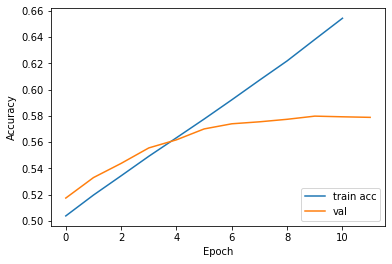

In [27]:
# Accuracy
plt.plot(history.history['accuracy'][1:], label='train acc')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

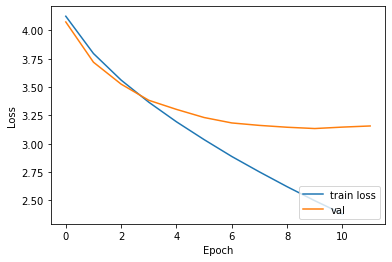

In [28]:
# Loss
plt.plot(history.history['loss'][1:], label='train loss')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [29]:
# Next, let’s build the dictionary to convert the index to word for target and source vocabulary:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [30]:
encoder_model, decoder_model = build_seq2seq_model_with_just_lstm_inference(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_lstm
)

In [31]:
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 300)    8739900     input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 400)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 400)]        0                                            
____________________________________________________________________________________________

In [32]:
decoder_model.layers[-3].input

[<KerasTensor: shape=(None, None, 300) dtype=float32 (created by layer 'embedding_1')>,
 <KerasTensor: shape=(None, 400) dtype=float32 (created by layer 'lstm_1')>,
 <KerasTensor: shape=(None, 400) dtype=float32 (created by layer 'lstm_1')>]

In [33]:
l = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

if len(l) % 3 != 0:
    while len(l) % 3 != 0:
        l.append(0)
print(l)

lst_i = 3
for i in range(0, len(l), 3):
    print(l[i:i + lst_i])

print(' '.join(['', 'james', 'ethan', '', 'tony']))
print(' '.join(' '.join(['', 'james', 'ethan', '', 'tony']).split()))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 0, 0]
[1, 2, 3]
[4, 5, 6]
[7, 8, 9]
[10, 0, 0]
 james ethan  tony
james ethan tony


In [34]:
def seq2summary(input_sequence):
    new_string = ''
    for i in input_sequence:
        if (
            (i != 0 and i != target_word_index[start_token]) and
            (i != target_word_index[end_token])
        ):
            new_string = new_string + reverse_target_word_index[i] + ' '
    return new_string

In [35]:
def seq2text(input_sequence):
    new_string = ''
    for i in input_sequence:
        if i != 0:
            new_string = new_string + reverse_source_word_index[i] + ' '
    return new_string

In [101]:
print(len(x_val_padded))
print(len(y_val_padded))

5431
5431


In [120]:
text_list = []
head_list = []
summ_list = []
lim = 200

for i in range(0, lim):
    text_list.append(seq2text(x_val_padded[i]))
    head_list.append(seq2summary(y_val_padded[i]))
    summ_list.append(decode_sequence_seq2seq_model_with_just_lstm(
        x_val_padded[i].reshape(1, max_text_len), encoder_model,
        decoder_model, reverse_target_word_index, reverse_source_word_index, target_word_index
    ))
    print("Decoding Summary #", i, " .......")

for i in range(0, lim):
    str = ''
    ctr = 0
    for charac in summ_list[i]:
        # print(charac)
        if charac == ' ':
            ctr += 1
        if ctr > 1:
            str = str + charac
    str = ' '.join(str.split(' ')[:-1])
    print(str)
    summ_list[i] = str
    
for j in range(0, lim):
    head_list[j] = head_list[j][:-1]
    str_ = ''
    ctr_ = 0
    for charac_ in head_list[j]:
        # print(charac)
        if charac_ == ' ':
            ctr_ += 1
        if ctr_ > 1:
            str_ = str_ + charac_
    str_ = ' '.join(str_.split(' ')[:-1])
    print(str_)
    head_list[j] = str_

Decoding Summary # 0  .......
Decoding Summary # 1  .......
Decoding Summary # 2  .......
Decoding Summary # 3  .......
Decoding Summary # 4  .......
Decoding Summary # 5  .......
Decoding Summary # 6  .......
Decoding Summary # 7  .......
Decoding Summary # 8  .......
Decoding Summary # 9  .......
Decoding Summary # 10  .......
Decoding Summary # 11  .......
Decoding Summary # 12  .......
Decoding Summary # 13  .......
Decoding Summary # 14  .......
Decoding Summary # 15  .......
Decoding Summary # 16  .......
Decoding Summary # 17  .......
Decoding Summary # 18  .......
Decoding Summary # 19  .......
Decoding Summary # 20  .......
Decoding Summary # 21  .......
Decoding Summary # 22  .......
Decoding Summary # 23  .......
Decoding Summary # 24  .......
Decoding Summary # 25  .......
Decoding Summary # 26  .......
Decoding Summary # 27  .......
Decoding Summary # 28  .......
Decoding Summary # 29  .......
Decoding Summary # 30  .......
Decoding Summary # 31  .......
Decoding Summary #

In [124]:
print(text_list[113], '\n')
print(head_list[113], '\n')
print(summ_list[113])

children madhya pradeshs ar village teaching policthemen panna police station skateboard ar houses one indias largest skate parks aar castle often considered indias first rural founded community activist ulrike reinhard officials panna reportedly talks ulrike plan skateboarding programme officers  

 teach cops skate mp village 

 mp village runs building village


In [125]:
from rouge_n_eval import *

In [126]:
scores = rouge_eval(head_list, summ_list)
# print(head_list[1], '\n')
# print(summ_list[1], '\n')
for key, value in scores.items():
    print(key, ' : ', value)

rouge-1  :  {'f': 0.1785041319826761, 'p': 0.19638095238095232, 'r': 0.17040873015873015}
rouge-2  :  {'f': 0.05412662257036617, 'p': 0.058249999999999996, 'r': 0.052642857142857144}
rouge-l  :  {'f': 0.18112007160440954, 'p': 0.18966666666666665, 'r': 0.1844484126984127}


In [56]:
# # Testing on training data
# for i in range(0, 2):
#     print(f"# {i+1} News: ", seq2text(x_train_padded[i]))
#     print("Original summary: ", seq2summary(y_train_padded[i]))
#     print(
#         "Predicted summary: ",
#         decode_sequence_seq2seq_model_with_just_lstm(
#             x_train_padded[i].reshape(1, max_text_len), encoder_model,
#             decoder_model, reverse_target_word_index, reverse_source_word_index, target_word_index
#         )
#     )
#     print()